In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import torch as th
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px

from morphomics.io.io import save_obj, load_obj
from morphomics.nn_models import train_test
from utils import load_toml, run_toml, get_2d, mask_pi, get_base, inverse_function

from plot import plot_2d, plot_pi, plot_dist_matrix, plot_vae_dist

In [2]:
path = 'results/vae/trained_vae'
my_pip = load_obj(path)
vae_pip = my_pip.metadata
mf = my_pip.morphoframe['v1_pi']
# Reset index and store the old index in a new column
mf = mf.reset_index()  # Resets the index and adds the old index as a column
# Rename the old index column to 'old_idcs'
mf.rename(columns={'index': 'old_idcs'}, inplace=True)
pis = mf['pi']
pi_example = pis.iloc[0]

NameError: name 'load_obj' is not defined

In [4]:
vae_pip

{'pixes_tokeep': array([   0,    1,    2, ..., 9087, 9088, 9089]),
 'standardizer': StandardScaler(),
 'fitted_pca_vae': [PCA(n_components=64),
  VAE(
    (encoder): Encoder(
      (model): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): SELU()
        (2): Linear(in_features=32, out_features=16, bias=True)
        (3): SELU()
        (4): Linear(in_features=16, out_features=8, bias=True)
        (5): SELU()
        (6): Linear(in_features=8, out_features=4, bias=True)
      )
      (mean): Linear(in_features=4, out_features=2, bias=True)
      (log_var): Linear(in_features=4, out_features=2, bias=True)
    )
    (decoder): Decoder(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=8, bias=True)
        (1): SELU()
        (2): Linear(in_features=8, out_features=16, bias=True)
        (3): SELU()
        (4): Linear(in_features=16, out_features=32, bias=True)
        (5): SELU()
        (6): Linear(in_features=32, out_fe

In [5]:
def get_base(pi, pixes_tokeep):
    pi_full = np.zeros_like(pi_example)
    pi_full[pixes_tokeep] = pi
    return pi_full

In [6]:
# Create a new column for the condition (Model + Sex)
mf['Condition'] = mf['Model'] + "-" + mf['Sex']


# Apply threshold

In [7]:
pixes_tokeep = vae_pip['pixes_tokeep']
pis_threshold = pis.apply(lambda pi: mask_pi(pi, pixes_tokeep)[0])
pis_filtered = pis.apply(lambda pi: mask_pi(pi, pixes_tokeep)[1])

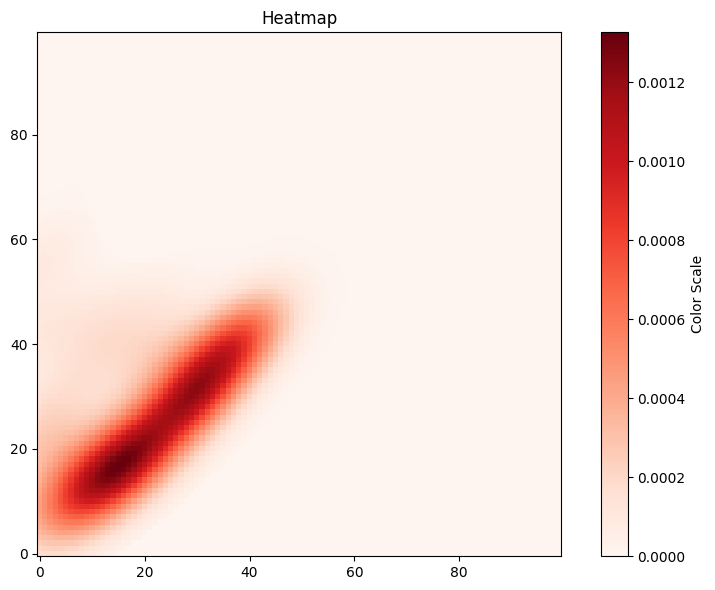

In [8]:
pi_th_example = pis_threshold.iloc[0]

plot_pi(pi_th_example, is_log = False)

# Apply Scaler

In [9]:
standardizer = vae_pip['standardizer']
pis_filtered_arr = np.vstack(pis_filtered)
pis_scaled = standardizer.transform(pis_filtered_arr)

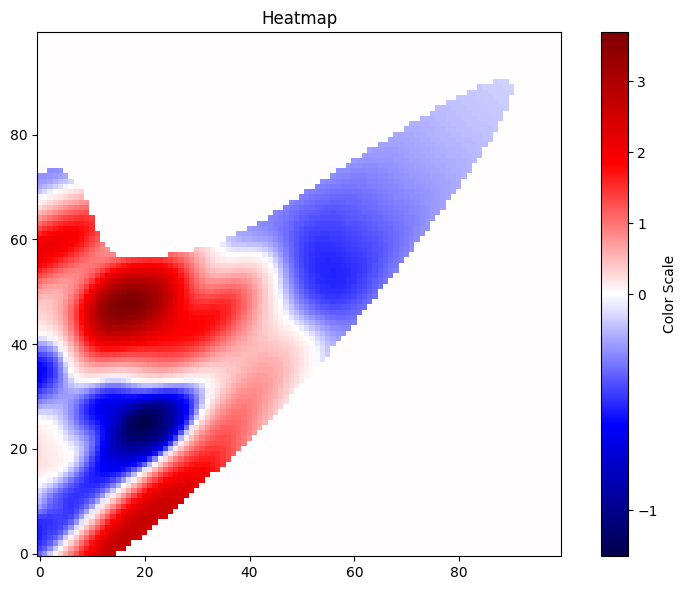

In [10]:
pi_scaled_full_example = get_base(pis_scaled[0], pixes_tokeep)
plot_pi(pi_scaled_full_example, is_log = False)

# Apply PCA

In [ ]:
pca = vae_pip['fitted_pca_vae'][0]

In [12]:
pis_pca = pca.transform(pis_scaled)

# VAE

In [13]:
vae = vae_pip['fitted_pca_vae'][1]

In [14]:
pis_pca_torch = th.tensor(pis_pca, dtype=th.float32)

In [15]:
pred, z_mean, z_log_var, mse = train_test.vae_test(data = pis_pca_torch,
                                                model = vae, 
                                                sample_size = 3,
                                               )
print('mse:', mse)
print('sample size:', z_mean.shape)
print('pred shape:', pred.shape)

mse: tensor(17.3685)
sample size: torch.Size([3004, 2])
pred shape: torch.Size([3, 3004, 64])


In [1]:
vae

NameError: name 'vae' is not defined

In [16]:
mf.keys()

Index(['old_idcs', 'Layer', 'Model', 'Sex', 'Animal', 'file_name', 'file_path',
       'swc_array', 'cells', 'barcodes', 'nb_bars', 'pi', 'trees',
       'nb_children', 'nb_trunks', 'max_length_bar', 'pca_vae', 'Condition'],
      dtype='object')

come back to pi

In [17]:
pred_processed_pi_mean = pred.mean(dim=0)
mf['pred'] = list(pred_processed_pi_mean)
pred_processed_pi = pred_processed_pi_mean.cpu().detach().numpy()  # If it's a PyTorch tensor, convert it to NumPy
pred_scaled_pi = pca.inverse_transform(pred_processed_pi)
pred_filter_pi = standardizer.inverse_transform(pred_scaled_pi)
mf['pi_filter_pred'] = list(pred_filter_pi)
mf['pi_pred'] = mf['pi_filter_pred'].apply(lambda pi: get_base(pi, pixes_tokeep))

interpolation

In [18]:
nb_points = 10  # Change this to the desired number of vectors
x_values = np.linspace(-1.25, 1.25, nb_points)
interpolation = np.column_stack((x_values, np.zeros_like(x_values)))

In [19]:
mf.keys()

Index(['old_idcs', 'Layer', 'Model', 'Sex', 'Animal', 'file_name', 'file_path',
       'swc_array', 'cells', 'barcodes', 'nb_bars', 'pi', 'trees',
       'nb_children', 'nb_trunks', 'max_length_bar', 'pca_vae', 'Condition',
       'pred', 'pi_filter_pred', 'pi_pred'],
      dtype='object')

In [20]:
mf_interpolation = pd.DataFrame()
mf_vae_kxa =  mf[mf['Model'].isin(['1xSaline_4h', '1xKXA_4h'])].copy()
mf_interpolation['Condition'] = mf_vae_kxa['Condition']
mf_interpolation['pca_vae'] = mf_vae_kxa['pca_vae']


# Add interpolation lines 
mf_interpolation_ = pd.DataFrame(data=nb_points*['interpolation'], columns = ['Condition'])
mf_interpolation_['pca_vae'] = list(interpolation)
mf_inter = pd.concat((mf_interpolation, mf_interpolation_)).reset_index(drop=True)
# Add color for interpolation 
from plot import merged_dict
color_dict = dict(merged_dict, **{'interpolation': 'rgb(250, 0, 0)'})

In [21]:
plot_2d(mf_inter,
        feature='pca_vae', 
        title = 'p',
        conditions = ['Condition'],
        colors= color_dict,
        name = None)

decode interpolation

In [3]:
pred_pi_list = []
for pt in interpolation:
    pred_pi = inverse_function(pt, model = vae, pca = pca, scaler = standardizer, filter=pixes_tokeep)
    pred_pi = get_2d(pred_pi)
    pred_pi_list.append(pred_pi)

NameError: name 'interpolation' is not defined

/tmp/ipykernel_432491/1827803149.py:31: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



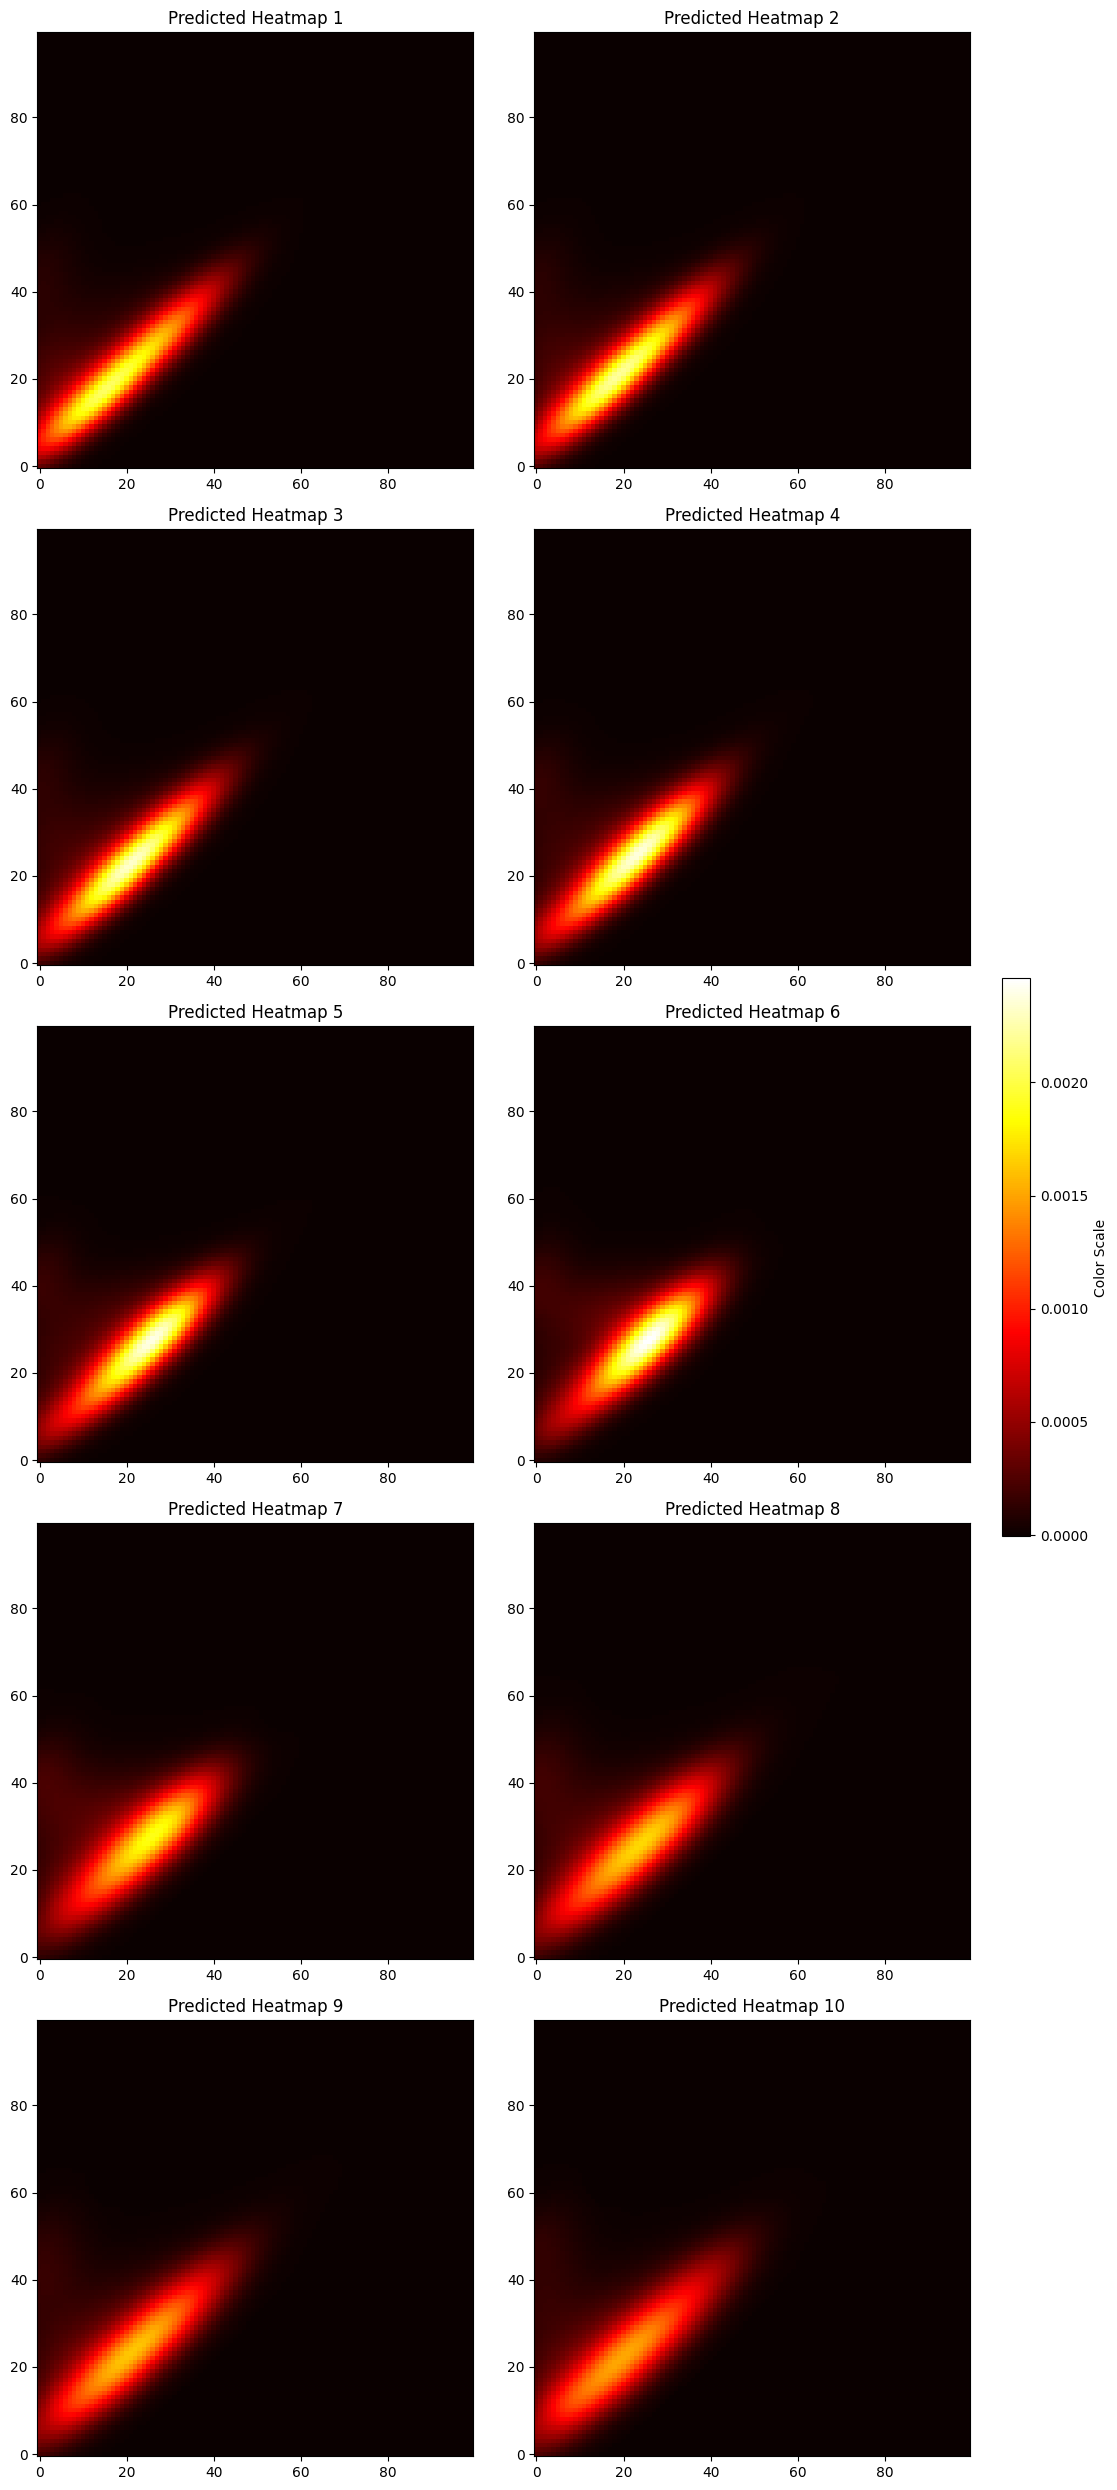

In [23]:
pred_pi_list = np.array(pred_pi_list)
# Assuming pred_inter_2 is your dataset of predicted matrices
num_images = pred_pi_list.shape[0]

# Calculate the number of rows needed for 2x2 plots
num_rows = (num_images + 1) // 2  # Round up for odd numbers

# Create a figure for the plots
fig, ax = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))  # Adjusting figsize for better visibility

# Define vmin and vmax for normalization
vmin = np.min(pred_pi_list)
vmax = np.max(pred_pi_list)

for i in range(num_rows):
    for j in range(2):
        index = i * 2 + j  # Compute the index for the flattened matrix
        if index < num_images:
            # Plot the predicted heatmap with the inverted hot colormap
            cax = ax[i, j].imshow(pred_pi_list[index], cmap='hot', vmin=vmin, vmax=vmax, interpolation='nearest', origin = 'lower')
            ax[i, j].set_title(f'Predicted Heatmap {index + 1}')
        else:
            ax[i, j].axis('off')  # Turn off the axis for blank spaces

# Create a single colorbar that spans all heatmaps
# Use the first heatmap's axes to set the colorbar
cbar = fig.colorbar(cax, ax=ax[:, :], orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Color Scale')  # Optional: Add a label to the colorbar

# Adjust layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the right side to give space for the colorbar

plt.show()


Latent Space Coherence

In [24]:
point_origin = np.array([0,0])
pi_origin = inverse_function(point_origin, model = vae, pca = pca, scaler = standardizer, filter=pixes_tokeep)
pi_origin_2d = get_2d(pi_origin)

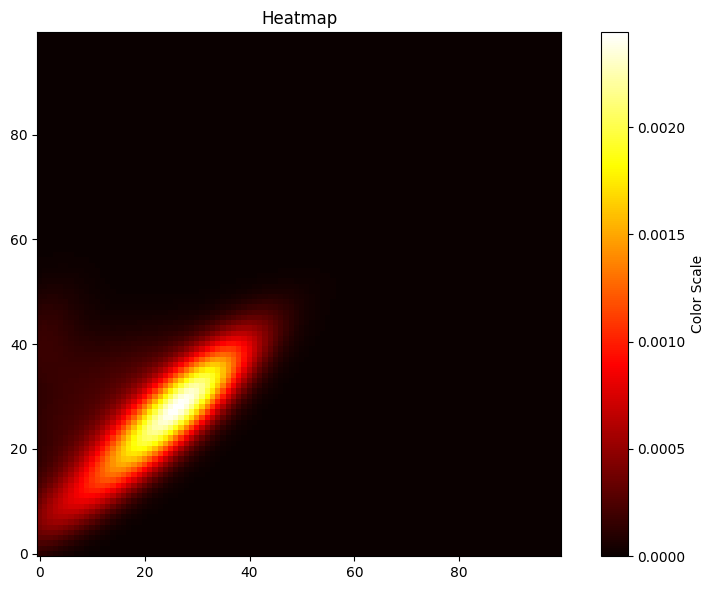

In [25]:
plot_pi(pi_origin_2d, cmap='hot')

In [26]:
mf.loc[:, 'dist_2d'] = mf['pca_vae'].apply(lambda p: np.linalg.norm(p - point_origin))
mf.loc[:, 'dist_pi_pred'] = mf['pi_pred'].apply(lambda p: np.linalg.norm(p - pi_origin))
mf.loc[:, 'dist_pi'] = mf['pi'].apply(lambda p: np.linalg.norm(p - pi_origin))

/tmp/ipykernel_432491/1346798651.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



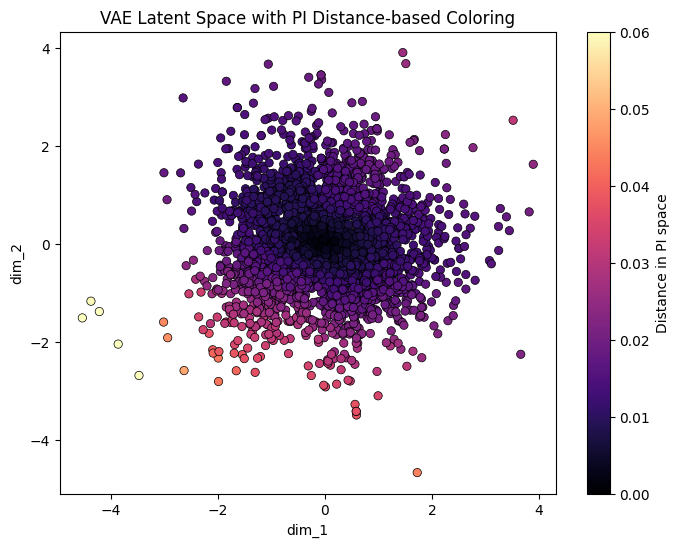

In [28]:
plot_vae_dist(mf, points = 'pca_vae', dist='dist_pi_pred', vmin=0.0, vmax=0.06)

/tmp/ipykernel_432491/1346798651.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



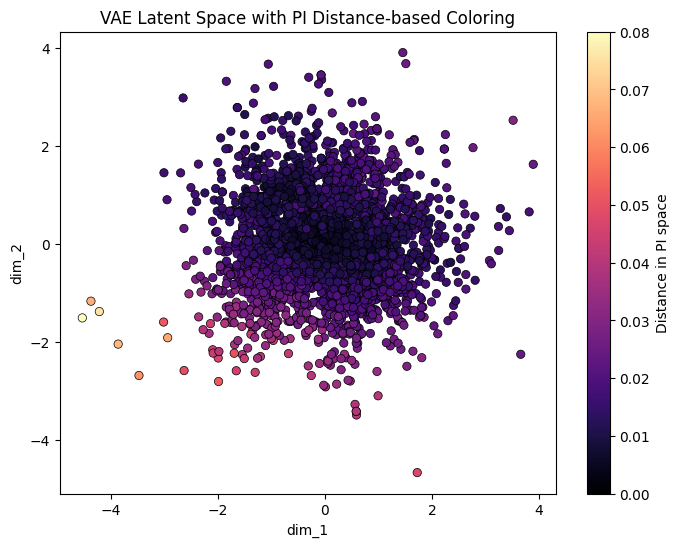

In [29]:
plot_vae_dist(mf, points = 'pca_vae', dist='dist_pi', vmin=0.0, vmax=0.08)

MSE

In [30]:
mf.loc[:, 'mse'] = mf.apply(lambda row: np.linalg.norm(row['pi_pred'] - row['pi']), axis=1)

/tmp/ipykernel_432491/1346798651.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



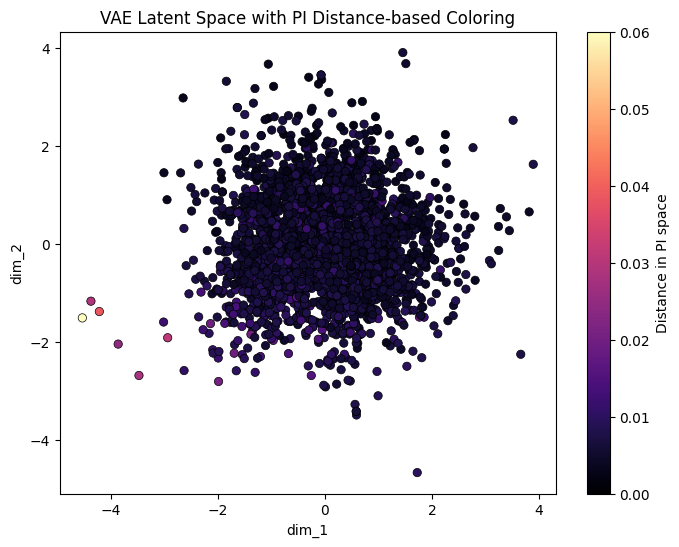

In [31]:
plot_vae_dist(mf, points = 'pca_vae', dist='mse', vmin=0.0, vmax=0.06)
